# News Summary

## 학습 목표

* Extractive/Abstractive summarization 이해하기
* 단어장 크기를 줄이는 다양한 text normalization 적용해보기
* seq2seq의 성능을 Up시키는 Attention Mechanism 적용하기

## Text Summarization

### 추출적 요약

* 문장들을 추출해서 요약하는 방식
* 문장 분류(Text Classification)
* TextRank 알고리즘

### 추상적 요약

* 내용이 요약된 새로운 문장을 생성
* 자연어 생성(Natural Language Generation, NLG)
* RNN으로 가능할거 같지만 장기의존성(long term dependencies : vanishing gradient + exploding gradient) 문제가 발생한다.

## Train text summarization

### seq2seq

<img src = 'img/seq2seq.png'>

* 첫 번째 RNN인 Encoder로 입력하면 인코더는 이를 하나의 고정된 벡터로 변환.
* 해당 벡터를 문맥 정보를 가지고 있는 컨텍스트 벡터(context vector)라고 합니다.
* 두 번째 RNN인 Decoder는 이 컨텍스트 벡터를 받아 한 단어씩 생성해내서 요약 문장을 완성

### LSTM 사용

<img src = 'img/LSTM.png' height = '50%' width = '50%'>

* Encoder 와 Decoder 둘 다 LSTM 사용
* 다음 time step 셀에 hidden state 뿐 아니라 cell state도 함께 전달
* Encoder 가 Decoder 에게 전달하는 컨텍스트 벡터 또한 hidden state h 와 cell state c 2개의 값 모두 존재

### 시작과 종료 토큰

<img src = 'img/Token.png' height = '50%' width = '50%'>

* Decoder에서는 시작 토큰 SOS가 입력되면 단어를 계속 생성하고 EOS를 예측하는 순간까지 멈추지 않는다.
* 이러한 토큰 전처리를 통해 어디서 멈춰야 하는지 알려줘야 한다.

### Attension mechanism

<img src = 'img/Attention.png' height = '50%' width = '50%'>

* Encoder의 모든 step의 hidden state의 정보가 컨텍스트 벡터에 전부 반영
* Decoder의 현재 time step 예측에 Encoder의 각 step이 얼마나 영향을 미치는지에 따른 가중합으로 계산
* Encoder의 hidden state의 가중치는 Decoder의 현재 스텝이 어디냐에 계속 바뀜

## Data 준비

### Library 불러오기

* NLTK(Natural Language Toolkit) : 자연어 처리용 라이브러리
* 해당 라이브러리의 불용어(stopwords) 사용 예정

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /home/aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 데이터 불러오기

In [2]:
data = pd.read_csv('data/Reviews.csv', nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### 랜덤한 15개 샘플 출력

In [4]:
data = data[['Text','Summary']]
data.head()

data.sample(15)

,Text,Summary
70945,I recently went back to school and am up late ...,Good Snack for Studying
1797,in my book. You can eat one serving with ease ...,Pop Chips Are Tops
14218,These were such a hit at my latest cocktail pa...,Delicious
85963,You know those cans of air you buy to clean yo...,Upside Down Canned Air
5434,"100% ground Arabica beans. Not my favorite, bu...",Good light to medium brew
85065,The minute I tried this I was instantly hooked...,It's sad just how delicious this juice is
44316,This tea works on my fiance's digestive track ...,Tea that works to clear all digestive stoppage.
36746,"Where I come from ""bait & switch"" is called fr...",Bait & Switch fraud!
19240,"I guess the tin isn't totally airtight, since ...",Smooth and fragrant
17056,OK so I bought the Sam's Club Fruit Snacks thi...,"Don't be fooled by the Sams Club ""fruit"" snacks"


## 데이터 정리하기

### 중복과 NULL 제거

#### 중복 확인 및 제거

* 중복 확인
* [pandas.DataFrame.nunique](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html)
* 특정 축에 대한 유일한 값의 개수 구하기

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


* 중복 제거
* [pandas.DataFrame.drop_duplicates](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html)
* inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다

In [6]:
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


#### NULL 확인 및 제거

* [pandas.DataFrame.isnull](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html#pandas.DataFrame.isnull)
* null 인 경우 True 아니면 False를 리턴하고 이에 대한 sum 이므로 개수가 나온다.

In [7]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


* [pandas.DataFrame.dropna](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html?highlight=dropna#pandas.DataFrame.dropna)
* NULL 값 1개 제거

In [8]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


### 텍스트 정규화와 불용어 제거 준비

* Text Normalization
* 같은 의미인데도 다른 표현으로 쓰이는 경우를 통일 시켜주는 작업
* it'll -> it will, mustn't -> must not 같이
* 정규화를 위한 사전을 구성 [출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


* 불용어(stopwords) : 자연어 처리시 도움이 안되는 단어들
* NLTK이 제공하는 불용어를 참조

In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

###  전처리 함수 만들기

* 텍스트 소문자화
* html 태그 제거
* () 문자열 제거
* " 제거
* 약어 정규화(준말 정규화)
* 소유격 제거
* 영어 외 문자 공백으로 변환

In [11]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, "lxml").text 
    sentence = re.sub(r'\([^)]*\)', '', sentence) 
    sentence = re.sub('"','', sentence) 
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","", sentence)
    sentence = re.sub("[^a-zA-Z0-9]", " ", sentence)
    
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

* 불용어 제거와 미제거로 나누어서 테스트

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


### 데이터 전체에 적용하기

* Text

In [13]:
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


* Summary

In [14]:
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


### 빈 값이 있는지 재확인

* 편의를 위해 DataFrame에 저장
* 빈 값을 Null 값으로 변환

In [15]:
data['Text'] = clean_text
data['Summary'] = clean_summary

data.replace('', np.nan, inplace=True)

* null값 확인

In [16]:
data.isnull().sum()

Text        0
Summary    61
dtype: int64

* null값 제거

In [17]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88364


## 훈련과 테스트 데이터 나누기

### 샘플의 최대 길이 정하기

* Text 와 Summary를 문장 단위로 나눈 뒤 개수를 세봅니다.

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1246
텍스트의 평균 길이 : 39.17314743560726
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.020630573536734


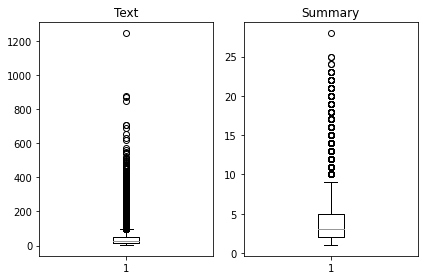

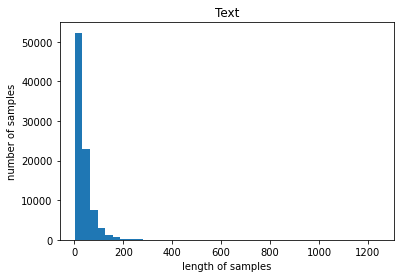

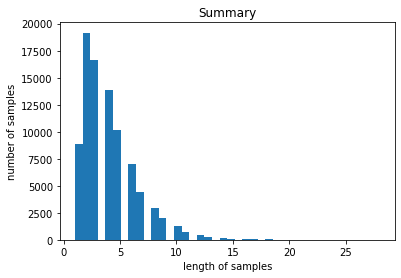

In [18]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* Text와 Summary의 적절한 최대 길이를 정해보기.

In [19]:
text_max_len = 50
summary_max_len = 8

* 해당 비율로 했을 때, 데이터가 몇 퍼센트인지 확인해봅시다.

In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [21]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7709134941831515
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9415033271468018


* 정해진 길이보다 길면 제외하도록 합니다.

In [22]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65488


### 시작과 종료 토큰

* Summary 데이터에 시작과 종료 토큰을 추가합니다.

In [23]:
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


* Numpy로 저장

In [24]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련과 테스트 데이터 분리

* encoder_input 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줌

In [25]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[56140 20078 19500 ... 58496 27080 13328]


* 만들어준 시퀀스를 이용해 샘플들을 섞어야 합니다.

In [26]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

* 데이터의 비율을 8:2 로 train와 test로 분리해줍니다.
* encoder는 label이 없고 decoder의 input으로 넘어가니
* endcoder는 input만 있습니다.
* decoder는 encoder로부터 input을 받고 정답 확인까지 해야하니 decoder input, target이 있습니다.
* train : 인코더 입력, 디코더 입력과 답
* test : 인코더 입력, 디코더 입력과 답
* train과 test는 

In [27]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13097


In [28]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52391
훈련 레이블의 개수 : 52391
테스트 데이터의 개수 : 13097
테스트 레이블의 개수 : 13097


## 정수 인코딩

### 단어 집합 만들기

* 훈련 데이터와 테스트 데이터 모두 정수로 바꿔주기
* 각 단어에 고유한 정수를 매핑하는 과정이 필요
* 해당 과정이 단어 집합(vocabulary) 만들기.

### Text 처리

#### Encoder_input_train 에 대한 단어 집합 만들기

In [29]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

* 단어의 등장 빈도수에 따라 나눠봅시다.\
* tokenizer.word_index : 단어 집합
* tokenizer.word_counts : 단어별 빈도수
* tokenizer.word_counts.items() : 단어 : 빈도수

In [30]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32831
등장 빈도가 6번 이하인 희귀 단어의 수: 24504
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8327
단어 집합에서 희귀 단어의 비율: 74.63677621759922
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.503973256094236


* 희귀 단어들이 70퍼나 되지만 정작 빈도 비율은 3퍼다.
* 이를 통해 단어 집합을 8천개로 잡아봅시다.

In [31]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

#### 정수 인코딩

* texts_to_sequences() : 텍스트의 단어들을 모두 정수로 변환하는 정수 인코딩

In [32]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[12, 105, 8, 3, 358, 444, 18, 111, 47, 811, 125, 283, 116, 475, 811, 47, 184, 964, 372, 433, 283, 34, 632, 185, 788, 434, 2, 87, 5], [136, 160, 41, 1350, 435, 697, 469, 47, 8, 265, 35, 241, 64, 27, 563, 2, 20, 265, 853, 98, 37, 10, 93, 42], [1565, 3351, 79, 137, 1418, 72, 95, 6, 142, 3, 22, 4421, 381, 27, 122, 103, 634, 426, 22, 105]]


### Summary 적용

In [33]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

* Summary는 6회 미만인 경우로 확인합니다.

In [34]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10663
등장 빈도가 5번 이하인 희귀 단어의 수: 8280
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2383
단어 집합에서 희귀 단어의 비율: 77.65169276938948
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.048532042148298


* 위 값을 통해 2천 정도로 크기를 잡읍시다.

In [35]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 226, 9, 605, 21], [1, 26], [1, 958, 1677], [1, 8, 471, 64, 175, 33, 340, 959], [1, 257, 495]]
target
decoder  [[226, 9, 605, 21, 2], [26, 2], [958, 1677, 2], [8, 471, 64, 175, 33, 340, 959, 2], [257, 495, 2]]


### 빈 샘플 삭제

* 빈도수가 낮은 단어들을 제거해주면서 완전히 빈 문장이 되어버릴 수 도 있다.
* 이는 길이가 비교적 긴 Text 보다 Summary에서 발생한다.
* 그렇기에 해당코드에서는 Summary 에서만 체크한다.
* 하지만 Summary 인 Decoder에 이미 input에 SOS target에 EOS 가 있으니 빈 문장은 1개의 길이를 가진다.
* 이를 이용해서 빈 문장의 idx를 찾아서 제거한다. 해당 행자체를 제거한다.(해당 idx의 encoder input, decoder input, target)

In [36]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1311
삭제할 테스트 데이터의 개수 : 353
훈련 데이터의 개수 : 51080
훈련 레이블의 개수 : 51080
테스트 데이터의 개수 : 12744
테스트 레이블의 개수 : 12744


### 패딩하기

In [37]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 모델 설계

### Encoder 설계

<img src = 'img/Dropout.png' height = '50%' width = '50%'>

* 임베딩 차원 : 128
* hidden size : 256
* LSTM을 총 3개의 층으로 구성
* hidden state의 크기 증가 : LSTM 1개의 용량을 늘림
* dropout : random으로 weight를 생략 - layer를 넘길때(ex) LSTM에서 다른 LSTM으로 갈때)
* recurrent dropout : RNN(LSTM) 같이 자기 자신을 time_step으로 반복할 때도 Overfitting이 일어날 수도 있으니까 time_step 마다 dropout을 시켜줌

In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

2022-09-02 18:09:35.536468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-02 18:09:36.081522: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6322 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


### Decoder 설계

* Decoder 설계시 Encoder와 거의 유사하지만 initial_state = h ,c 로 둔다.

In [39]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

* 출력 층

In [40]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

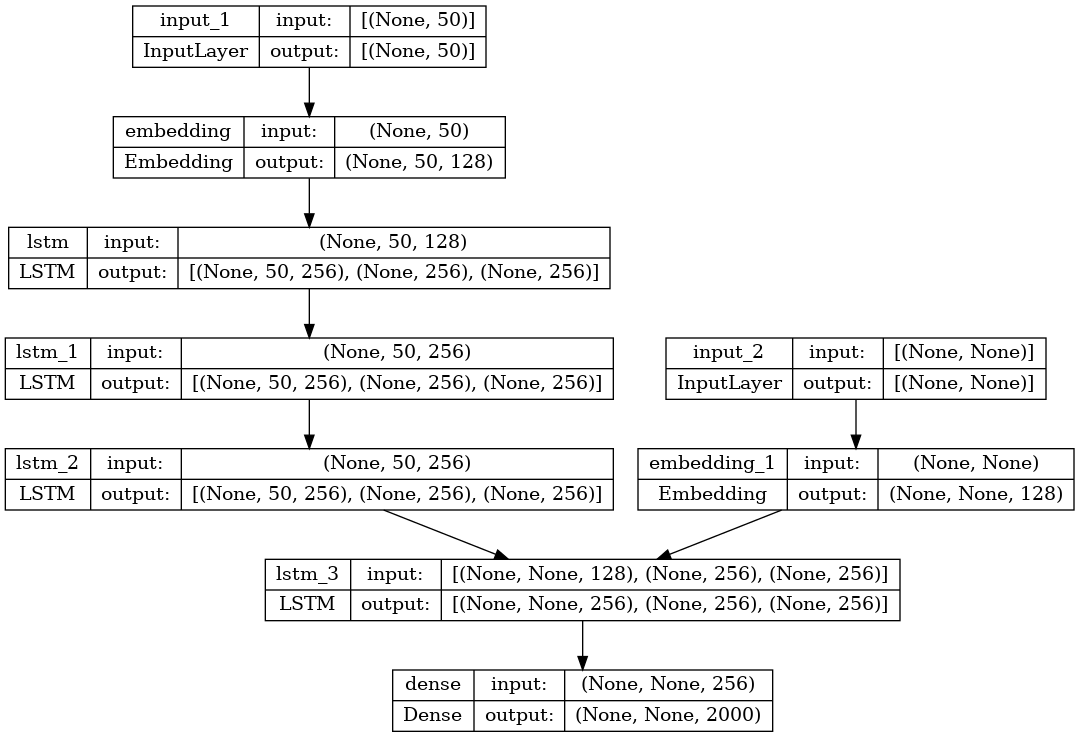

In [41]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

### Attention mechanism

In [42]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

* Encoder의 hidden state와 Decoder의 hidden state를 Attention 함수의 입력으로 사용
* Attention의 결과를 Decoder의 hidden state와 연결

## 모델 훈련하기

* EarlyStopping : 특정 조건이 충족되면 훈련을 멈춤
* 해당 코드에서는 val_loss 가 줄지않고 2개 증가하면 멈춤
* 다른 예시로운 특정 수준의 이상의 prediction이 나오면 멈추게 할 수 있다.

In [43]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50


2022-09-02 18:09:42.336385: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2070" frequency: 1455 num_cores: 36 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 6630080512 bandwidth: 352064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-09-02 18:09:44.014797: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


199/200 [============================>.] - ETA: 0s - loss: 2.7080

2022-09-02 18:09:56.780951: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2070" frequency: 1455 num_cores: 36 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 6630080512 bandwidth: 352064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


200/200 [==============================] - 20s 61ms/step - loss: 2.7073 - val_loss: 2.4188
Epoch 2/50
200/200 [==============================] - 11s 53ms/step - loss: 2.3623 - val_loss: 2.2688
Epoch 3/50
200/200 [==============================] - 11s 53ms/step - loss: 2.2178 - val_loss: 2.1565
Epoch 4/50
200/200 [==============================] - 11s 54ms/step - loss: 2.1058 - val_loss: 2.0809
Epoch 5/50
200/200 [==============================] - 11s 54ms/step - loss: 2.0189 - val_loss: 2.0154
Epoch 6/50
200/200 [==============================] - 11s 54ms/step - loss: 1.9530 - val_loss: 1.9767
Epoch 7/50
200/200 [==============================] - 11s 54ms/step - loss: 1.9001 - val_loss: 1.9484
Epoch 8/50
200/200 [==============================] - 11s 54ms/step - loss: 1.8539 - val_loss: 1.9184
Epoch 9/50
200/200 [==============================] - 11s 54ms/step - loss: 1.8114 - val_loss: 1.9057
Epoch 10/50
200/200 [==============================] - 11s 53ms/step - loss: 1.7742 - val_los

* 시각화

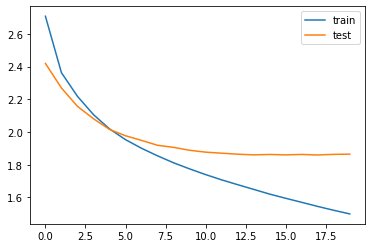

In [44]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Inference Model

* 훈련 후 모델이 실제 동작 할때 : Inference 단계

### 3개의 사전 준비

In [45]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

### 모델 설계

* seq2seq : 훈련할 때와 실제 동작이 다르므로 그에 맞게 모델 설계
* Encoder와 Decoder의 통짜 모델 하나만 준비.
* 인퍼런스 단계에서는 정답이 없다. 인코더와 디코더 모델을 분리하여 설계

In [46]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

### Attention mechanism

* 새로운 레이어를 추가
* encoder의 h,c 와 decoder의 h,c를 가져온다.
* encode의 h,c를 가져올 비율은 decoder h,c 로 결정한다.

In [47]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### 인퍼런스 단계에서 실행한 함수 설정

In [48]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 모델 테스트

### 정수 -> 텍스트

In [49]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [50]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : coffee perfect morning strong gives perfect smooth jolt crave highly recommended 
실제 요약 : my favorite 
1/1 [==============================] - 0s 17ms/step


2022-09-02 18:13:23.546963: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2070" frequency: 1455 num_cores: 36 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 6630080512 bandwidth: 352064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


예측 요약 :  great coffee


원문 : closest thing sugar taste ever used taste use xylitol coffee tea yum love 
실제 요약 : amazing 
1/1 [==============================] - 0s 18ms/step
예측 요약 :  great tea


원문 : never bought cereal amazon highly doubt would ever price asking however cereal really awesome love many different foods yet still works really fun eat wondering get next serving batch fact healthy makes love even 
실제 요약 : completely awesome 
1/1 [==============================] - 0s 18ms/step
예측 요약 :  great cereal


원문 : using sf bay coffee fog chaser several months become coffee choice select others change pace use fog chaser everyday selection highly recommend 
실제 요약 : fog chaser is great coffee 
1/1 [==============================] - 0s 17ms/step
예측 요약 :  great coffee


원문 : good kind fat tastes great actually like taste better butter similar quality rich blends well foods way healthier butter aggressive tasting olive oil substituted butter every chance get good results please buy amazon

## 추출적 요약

* 추상적 요약이 아닌 추출적 요약

### 데이터 다운로드

In [2]:
import requests
from summa.summarizer import summarize

In [3]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [4]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

### Summarize 사용

인자
* text (str) : 요약할 테스트.
* ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
* words (int or None, optional) – 출력에 포함할 단어 수.  
  만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
* split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [8]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends t

In [6]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']
<class 'str'>


In [56]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
